# [`01-mta`](https://github.com/thisismetis/nyc18_ds14/blob/master/challenges/challenges_questions/01-mta/README.md)

| Topic | **Challenge Set 1** (01-mta) |
| :---- | :--------------------------- |
| Subject | Explore MTA turnstile data |
| Date | 01/13/2018 |
| Name | Brad Solomon |
| Worked with | Audrey Baker, Brad Davies, Kevin Stern, Will Stokvis |

# Challenge 1

First, I create a list of dates (their string representations, actually) using an anchor `datetime.date` and `timedeltas`.  (This could be done using `pandas.date_range().strftime()` also.)  These are the 3 Saturdays ending January 13, 2018.  We will loop through this list, inserting each date-string into our "base url" to get a text file that we can then parse, combine, and clean.

The [requested](https://github.com/thisismetis/nyc18_ds14/tree/master/challenges/challenges_questions/01-mta#challenge-1) output is a dictionary with 4-tuples as keys and time/entries as (nested) list values.  I use `collections.defaultdict` for this purpose.  However, in our groupwork/project **we determined that LINENAME must be added to this tuple to create a true primary key for each SCP (turnstile).**  They keys are then:

> `(LINENAME, STATION, C/A, UNIT, SCP)`

For each of the three urls, I build an in-memory stream with `stream=True`:

> By default, when you make a request, the body of the response is downloaded immediately. You can override this behaviour and defer downloading the response body until you access the `Response.content` attribute with the `stream` parameter. [[source](http://docs.python-requests.org/en/master/user/advanced/#body-content-workflow)]

This allows us to pass a generator to `csv.reader()`.

`next` is used to ignore the header row.  (Although this might be a good place to use a `namedtuple`.)

The other significant speedup comes from **using `datetime.strptime` rather than `dateutil.parser`** to concatenate DATE/TIME fields into a `datetime` object.  We can pass the format expliclty rather than needing to infer it.  **This creates around an 8x speedup.**

The inner `for`-loop populates the "master" data dictionary, `mta`.  The construction itself uses iterable unpacking with "throwaway" values denoted by underscores.  Because our default `value` is a Python list, we can call `.append()` for each field.

In [1]:
from codecs import iterdecode
from collections import defaultdict
from contextlib import closing
import csv
import datetime
import timeit

import requests

# C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
mta = defaultdict(list)
fmt = '%m/%d/%Y %H:%M:%S'
week = datetime.timedelta(7)
dt = datetime.date(2018, 1, 13)
dates = [date.strftime('%y%m%d') for date in [dt - 2 * week, dt - week, dt]]

start = timeit.default_timer()

for date in dates:
    with closing(requests.get(url.format(date), stream=True)) as text:
        # Could also implement csv.DictReader here
        reader = csv.reader(iterdecode(text.iter_lines(), 'utf-8'),
                            delimiter=',', quotechar='"')
        _ = next(reader)
        for ca, unit, scp, stn, lname, _, date, time, _, entry, _ in reader:
            # Dropped fields: DIVISION, DESC, EXITS
            dt = datetime.datetime.strptime('{} {}'.format(date, time), fmt)
            mta[(lname, stn, ca, unit, scp)].append([dt, int(entry)])

time = timeit.default_timer() - start

# "Inner" length of dict with nested keys
size = 0
for record in mta.values():
    size += len(record)

print('Built {:,} records in {:0.1f} seconds'.format(size, time))

Built 598,998 records in 12.1 seconds


Here is the first key and its first 5 entries:

In [2]:
from pprint import pprint
k = list(mta)[0]
print('Station identifier:\n', k, '\n', sep='')
print('First five records for given station ID:')
pprint(mta[k][:5])

Station identifier:
('NQR456W', '59 ST', 'A002', 'R051', '02-00-00')

First five records for given station ID:
[[datetime.datetime(2017, 12, 23, 3, 0), 6455840],
 [datetime.datetime(2017, 12, 23, 7, 0), 6455856],
 [datetime.datetime(2017, 12, 23, 11, 0), 6455899],
 [datetime.datetime(2017, 12, 23, 15, 0), 6456038],
 [datetime.datetime(2017, 12, 23, 19, 0), 6456327]]


## LINENAME correction

As discovered by our group (Group4), there are some naming issues with `LINENAME` in the raw dataset.  For instance, Borough Hall may use either of these LINENAMEs:

- R2345
- 2345R

While Times Sq-42 St may use:

- 1237ACENQRS
- 1237ACENQRSW

As a reminder, we need LINENAME because we have a small number of different stations with the same STATION, UNIT, CA, SCP identifier.  (I.e. 14th St.)

One other small error we discovered was usage of "14 ST" and "14TH STREET" interchangably, to refer to the same station.

Both of these issues are addressed below:

In [3]:
names = {
    'BOROUGH HALL': ['2345R', 'R2345'],
    'ATL AV-BARCLAY': ['BDNQR2345', '2345BDNQR'],
    '59 ST COLUMBUS': ['1ABCD', 'ABCD1'],
    '59 ST': ['456NQRW', 'NQR456W'],
    '36 ST': ['MR', 'DNR'],
    '34 ST-PENN STA': ['123ACE', 'ACE'],
    '14 ST': ['1', '123FLM', 'FLM123'],
    'TIMES SQ-42 ST': ['1237ACENQRS', '1237ACENQRSW', 'ACENQRS1237W'],
    'CHAMBERS ST': ['123', 'ACE23']
    }

for station, linenames in names.items():
    for key in mta:
        if key[1] == '14TH STREET':
            ln, st, ca, un, scp = key
            mta[(ln, '14 ST', ca, un, scp)] = mta.pop(key)
        if key[1] == station and key[0] in linenames[1:]:
            ln, st, ca, un, scp = key
            # Modify key inplace, bringing all linenames
            #     into uniformity with 0th linename from `names`
            mta[(linenames[0], st, ca, un, scp)] = mta.pop(key)

We now have valid `(LINENAME, STATION, C/A, UNIT, SCP)` that allow us to drill down to the turnstile level.

# Challenge 2

Let's turn this into a time series.  Visual inspection seems to tell us that we have **observations every 4 hours**.  (3, 7, 11, 15, ... or (0, 4, 8, 12, ...)  In raw form, the ENTRIES and EXITS fields denote cumulative entries and exits relative to a (somewhat arbitrary) starting point, which is intermittently reset.

However, the [field description](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt) also notes that there are audits made at arbitrary intervals for a (presumably small) number of stations.

Therefore, it may be useful not only to convert cumulative entries to first discrete differences, but also **to add a corresponding field denoting the time interval that encompasses the difference.**  This helps us pay more attention to scale: 300 entries in 4 hours is very different from 300 entries in 23 minutes.

In [4]:
from datetime import timedelta

mta_hrs = dict.fromkeys(mta)
for k, v in mta.items():
    # [[date, entry], [date, entry]] --> [[date, date], [entry, entry]]
    days, entries = zip(*v)
    # First differences, so first entry will be NaN
    tds = [j - i for i, j in zip(days[:-1], days[1:])]
    diff = [j - i for i, j in zip(entries[:-1], entries[1:])]
    mta_hrs[k] = dict(zip(days[1:], zip(tds, diff)))

`mta_hrs` is now a `dict` with:
- keys resembling those of `mta`
- values which are dictionaries:
    - they keys for which are datetime objects, and
    - the values for which are tuples of (`timedelta`s, entries)

Here are some early-January morning records for the first key:

In [5]:
k1, *_ = list(mta_hrs)
print(k1)
v = mta_hrs[k1]
{dt: v for dt, v in v.items() if dt.day < 3 and dt.month == 1 and dt.hour < 12}

('NQRW', '5 AV/59 ST', 'A006', 'R079', '00-00-00')


{datetime.datetime(2018, 1, 1, 1, 0): (datetime.timedelta(0, 14400), 113),
 datetime.datetime(2018, 1, 1, 5, 0): (datetime.timedelta(0, 14400), 42),
 datetime.datetime(2018, 1, 1, 9, 0): (datetime.timedelta(0, 14400), 24),
 datetime.datetime(2018, 1, 2, 1, 0): (datetime.timedelta(0, 14400), 89),
 datetime.datetime(2018, 1, 2, 5, 0): (datetime.timedelta(0, 14400), 4),
 datetime.datetime(2018, 1, 2, 9, 0): (datetime.timedelta(0, 14400), 44)}

# Challenge 3

As mentioned above, the counts are (mostly) for 4-hour intervals.

There are several ways we could aggregate up to total daily entries:
1. We could use the **final value of each day less the final value from the previous day**.  If we alternatively just took the final value minus first value of each day, that would exclude a "chunk" of ridership from the close of Day 1 to the open of Day 2.  However, this method is error-prone because they are around 25 "typos" in the data that can only be corrected when honing in on the hourly level.
2. A second and safer way is to **create a grouping on the `day` attribute of our nested keys**, and sum the entries within each of these groups.  We'll use this method below.

But first, let's **check for erroneous entries** at the level of granularity we have now.  Some of these appear to be "flukes" rather than true outliers.  For example, on 1-22-17 at 12:00:00, the 14th St 01-03-00 turnstile (N078 R175 ACEL) had 8,476,560 cumulative entries.  The next recorded entry figure was 2,130,669,389 cumulative entries, 4 hours later at 16:00:00, implying a 4-hour difference of 2.1 billion riders.  

It is easy by visual inspection to find "legitimate" cases of 4-hour entry tallies in the 2,500-3,500 range.  It is necessary, therefore, to build some arbitrary "cutoff" point to screen out these errors.  We'll use **3,500 entries per 4 hours** as our cutoff threshold.  This implies a per-second rate of 0.243 entries per second.

To reiterate, the reason we use Method 2 is because it allows for us to check for issues at the 4-hour interval level, rather than day-level, as we would be forced to do under Method 1.

In [6]:
threshold = 3500/4/60/60
mta_hrs_clean = {k: {} for k in mta}

for turnstile, data in mta_hrs.items():
    for date, (td, entry) in data.items():
        # Also drop negative ridership and 0-times
        if td.total_seconds() == 0 or entry < 0:
            continue
        elif entry / td.total_seconds() < threshold:
            mta_hrs_clean[turnstile][date] = (td, entry)

In [7]:
size1, size2 = 0, 0
for a, b in zip(mta_hrs.values(), mta_hrs_clean.values()):
    size1 += len(a)
    size2 += len(b)
print('Records dropped: {} of {}'.format(size1-size2, size1))

Records dropped: 4958 of 594270


Now, to create a grouping on the day attribute of our nested keys, and sum the entries within each of these groups:

The recipe below uses [`itertools.groupby`](https://docs.python.org/3/library/itertools.html#itertools.groupby) to accomplish this.

> `itertools.groupby(iterable, key=None`
>
> Make an iterator that returns consecutive keys and groups from the iterable. The key is a function computing a key value for each element. If not specified or is None, key defaults to an identity function and returns the element unchanged. Generally, the iterable needs to already be sorted on the same key function.

We create a new dictionary (with default `None` values) from the keys of `mta`.  Each value in `mta` is an iterable (a nested list), which we group by the `.day` attribute of the `datetime` object within the list.

The second chunk of code gets us our first discrete differences.  Note that this will require us to *drop the first day* in each sub-series.  One Day 1 of each sub-time-series, we don't have a "previous day" value to use in our subtraction.

In [8]:
from itertools import groupby

mta_days = {k: {} for k in mta_hrs_clean}
for k, v in mta_hrs_clean.items():
    for day, grouping in groupby(v.items(), lambda x: x[0].date()):
        _, data = zip(*grouping)
        mta_days[k][day] = sum(entry for _, entry in data)

Here would be the alternative construction (Method 1 from above):

```python
from datetime import timedelta

mta_days = dict.fromkeys(mta)
for k, v in mta.items():
    day_ends = {}
    for day, data in itertools.groupby(v, lambda x: x[0].day):
        # Day's final observation i.e.
        # [datetime.datetime(2017, 12, 16, 23, 0), 6447190]
        *_, (time, entry) = data
        day_ends[time.date()] = entr
    # First difference of entries, paying attention to missing days
    diff = {k: np.nan for k in day_ends}
    td = timedelta(1)
    for d in diff:
        diff[d] = day_ends.get(d, np.nan) - day_ends.get(d - td, np.nan)
    mta_days[k] = diff
```

`mta_days` is now a nested dictionary:

In [9]:
print(type(mta_days))

# A hack to print first dictionary value by position
print(type(next(iter(mta_days.values()))))

<class 'dict'>
<class 'dict'>


`mta_days`'s keys are the same as `mta`'s.  `mta_days`'s values are dictionaries of `{datetime.date: difference}` pairs, with `difference` being an `int` denoting the daily first discrete difference, or `numpy.nan` where this difference is not available.

The first two keys:

In [10]:
k1, k2, *_ = list(mta_days)
print(k1)
print(k2)

('NQRW', '5 AV/59 ST', 'A006', 'R079', '00-00-00')
('NQRW', '5 AV/59 ST', 'A006', 'R079', '00-00-01')


And the first few records for the first key:

In [11]:
{k: v for k, v in mta_days[k1].items() if k.day < 8 and k.month == 1}

{datetime.date(2018, 1, 1): 591,
 datetime.date(2018, 1, 2): 1496,
 datetime.date(2018, 1, 3): 1613,
 datetime.date(2018, 1, 4): 1250,
 datetime.date(2018, 1, 5): 1427,
 datetime.date(2018, 1, 6): 868,
 datetime.date(2018, 1, 7): 637}

# Challenge 4

Here let's plot the daily turnstile registers for two turnstiles.

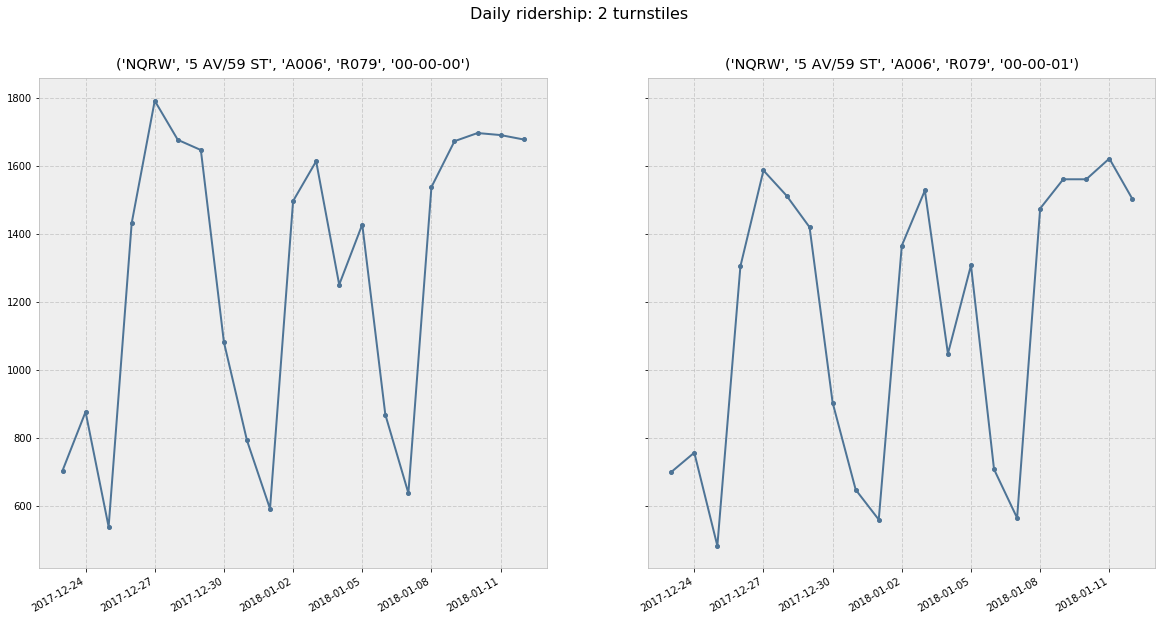

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

turnstiles = {
    k1: tuple(zip(*mta_days[k1].items())),
    k2: tuple(zip(*mta_days[k2].items()))
    }

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
for i, (k, v) in enumerate(turnstiles.items()):
    ax[i].plot(v[0], v[1])
    ax[i].set_title(k)
fig.suptitle('Daily ridership: 2 turnstiles', fontsize=16)
fig.autofmt_xdate()

What about higher-frequency ridership figures?  Let's take a turnstile from a heavily-trafficked station.

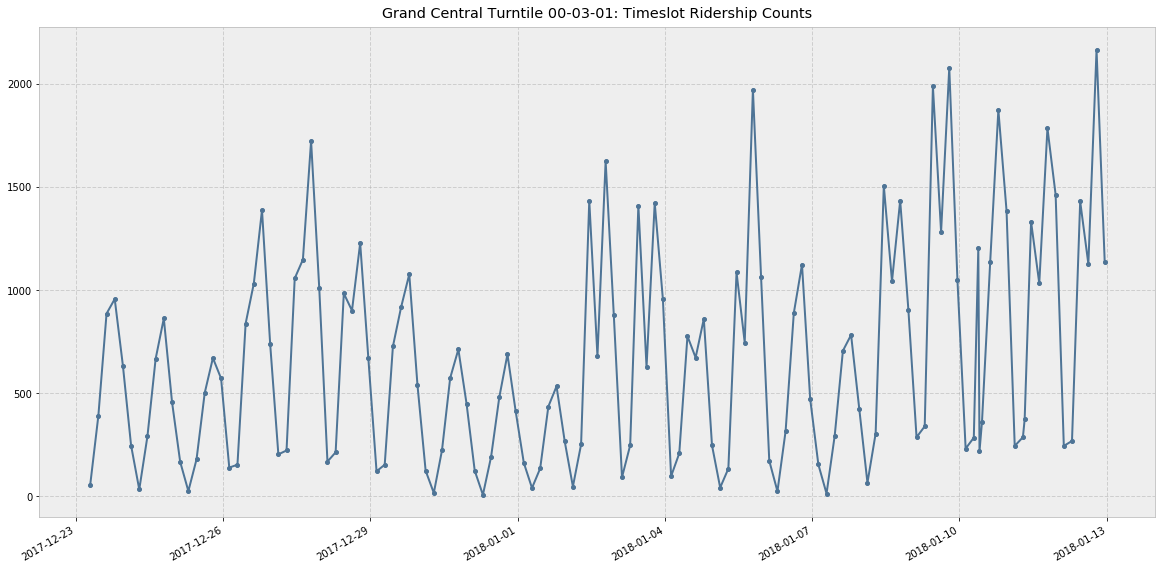

In [13]:
grd_ctrl = ('4567S', 'GRD CNTRL-42 ST', 'R238', 'R046', '00-03-01')
days, counts = tuple(zip(*mta_hrs[grd_ctrl].items()))
counts = [count for td, count in counts]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(days, counts)
ax.set_title('Grand Central Turntile 00-03-01: Timeslot Ridership Counts')
fig.autofmt_xdate()

# Challenge 5

Without having access to pandas' `groupby` facility, we can emulate similar functionality.

Our result here is a dict of `defaultdict`s, arguably an ideal data structure for this purpose.

In [14]:
# *don't* use `dict.fromkeys` here - reference issue!
booths = {k[:4]: defaultdict(int) for k in mta_days}
for turnstile, records in mta_days.items():
    for date, entry in records.items():
        booths[turnstile[:4]][date] += entry

Here's our first set of entries.  We have 4-tuple keys now:

In [15]:
k = next(iter(booths.keys()))
print(k, '\n', sep='')
# Entries for Dec 24-25
print({date: entry for date, entry in booths[k].items()
       if date.month == 12 and date.day in [24, 25]})

('NQRW', '5 AV/59 ST', 'A006', 'R079')

{datetime.date(2017, 12, 24): 5025, datetime.date(2017, 12, 25): 3646}


# Challenge 6

The results of Challenge 5 gave us `(LINENAME, STATION, C/A, UNIT)` keys.  This is analogous to a _group of turnstiles within a station_.

To roll up to the _station_ level, we need to eliminate `C/A` and `UNIT` (but retain LINENAME as it helps to separate different stations with the same station-name.

Mimicking the process from Challenge 5:

In [16]:
stations = {k[:2]: defaultdict(int) for k in mta_days}
for turnstile, records in mta_days.items():
    for date, entry in records.items():
        stations[turnstile[:2]][date] += entry

In [17]:
k = next(iter(stations.keys()))
print(k, '\n', sep='')
# Entries for Dec 24-25
print({date: entry for date, entry in stations[k].items()
       if date.month == 12 and date.day in [24, 25]})

('NQRW', '5 AV/59 ST')

{datetime.date(2017, 12, 24): 9216, datetime.date(2017, 12, 25): 7554}


# Challenge 7

To plot the time series for a station:

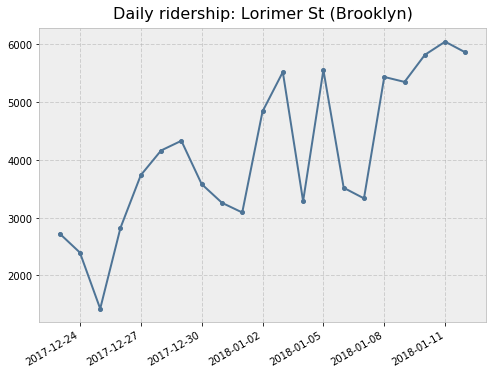

In [18]:
grd_ctrl = ('LG', 'LORIMER ST')
dates, riders = list(zip(*stations[grd_ctrl].items()))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dates, riders)
ax.set_title('Daily ridership: Lorimer St (Brooklyn)', fontsize=16)
fig.autofmt_xdate()

# Challenge 8

We have an unusual starting demarcation: our time series begins on a Saturday, and in fact that day is NaN, so our first valid data point is a on a Sunday:

In [19]:
day_of_week = [d.isoweekday() for d in dates]
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
namemap = dict(enumerate(names, start=1))
print('Days:\n', [namemap[day] for day in day_of_week], '\n\nRiders:\n', riders, sep='')

Days:
['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']

Riders:
(2725, 2396, 1425, 2824, 3734, 4161, 4329, 3580, 3257, 3089, 4836, 5518, 3285, 5553, 3516, 3333, 5433, 5347, 5815, 6043, 5857)


How can we pad with missing values to create a proper nxm array?

In [20]:
import numpy as np

start, *_, end = day_of_week
pad_width = (start-1, 7-end)
day_of_week = np.pad(day_of_week, pad_width=pad_width, 
                     mode='linear_ramp', end_values=(1, 7))
riders = np.pad(np.asarray(riders, dtype=np.float64), pad_width=pad_width, mode='constant', 
                constant_values=(np.nan, np.nan))
assert len(day_of_week) == len(riders)
day_of_week = day_of_week.reshape((-1, 7))
riders = riders.reshape((-1, 7))

Now let's plot this reshaped data:

In [21]:
riders

array([[   nan,    nan,    nan,    nan,    nan,  2725.,  2396.],
       [ 1425.,  2824.,  3734.,  4161.,  4329.,  3580.,  3257.],
       [ 3089.,  4836.,  5518.,  3285.,  5553.,  3516.,  3333.],
       [ 5433.,  5347.,  5815.,  6043.,  5857.,    nan,    nan]])

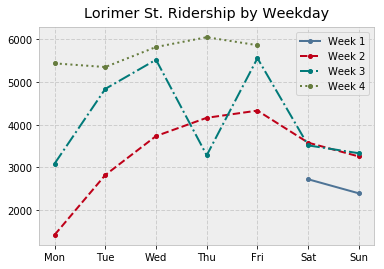

In [22]:
plt.plot(riders.T)
plt.xticks(range(0, 7), names)
plt.title('Lorimer St. Ridership by Weekday')
plt.legend(['Week {}'.format(i) for i in range(1, 5)])

# Challenge 9

Here are the ten stations with highest total ridership during the period examined:

In [23]:
from collections import Counter

totals = {station: np.nansum(list(v.values())) for station, v in stations.items()}
top10 = Counter(totals).most_common(10)
top10

[(('4567S', 'GRD CNTRL-42 ST'), 2101884),
 (('123ACE', '34 ST-PENN STA'), 1963188),
 (('BDFMNQRW', '34 ST-HERALD SQ'), 1751916),
 (('1237ACENQRS', 'TIMES SQ-42 ST'), 1529565),
 (('ACENQRS1237W', '42 ST-PORT AUTH'), 1244991),
 (('LNQR456W', '14 ST-UNION SQ'), 1015988),
 (('1ABCD', '59 ST COLUMBUS'), 1008499),
 (('BDFM', '47-50 STS ROCK'), 1001254),
 (('2345ACJZ', 'FULTON ST'), 918120),
 (('7', 'FLUSHING-MAIN'), 894313)]

# Challenge 10

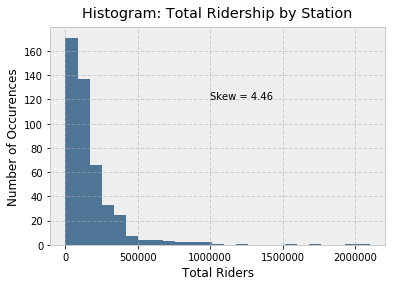

In [24]:
from scipy.stats import skew

n, bins, patches = plt.hist(totals.values(), bins=25)
plt.title('Histogram: Total Ridership by Station')
plt.ylabel('Number of Occurences')
plt.xlabel('Total Riders')
plt.text(1000000, 120, 'Skew = {:0.2f}'.format(
    skew(list(totals.values()))));